<a href="https://colab.research.google.com/github/adityarajiitmd/Deep-Learning-and-NLP/blob/main/Simple_Mixture_of_Expert_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.utils import to_categorical
import numpy as np
from tensorflow.keras.layers import Dropout

In [19]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255

num_classes = 10
y_train = to_categorical(y_train,num_classes)
y_test = to_categorical(y_test,num_classes)



In [20]:
from keras import layers, models

In [26]:
def create_expert_model(input_shape,num_outputs):
  model = models.Sequential([
      layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
      layers.Dropout(0.2), # Adds Dropout to the first hidden layer
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64,(3,3),activation='relu'),
      layers.Dropout(0.1), # Adds Dropout to the second hidden layer
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(128,(3,3),activation='relu'),
      layers.Dropout(0.1), # Adds Dropout to the second hidden layer
      layers.MaxPooling2D((2,2)),
      layers.Flatten(),
      layers.Dense(128,activation='relu'),
      layers.Dense(num_outputs,activation='softmax')
  ])
  return model


In [27]:
def create_gating_model(num_experts,num_outputs):
  model = models.Sequential([
      layers.Dense(64, activation='relu',input_shape=(num_experts,)),
      layers.Dense(num_outputs,activation='softmax')
  ])
  return model


In [28]:
def create_moe_model(input_shape, num_experts,num_outputs):
  expert_input = layers.Input(shape=input_shape,name='expert_input')
  expert_model = create_expert_model(input_shape,num_outputs)
  expert_output = expert_model(expert_input)
  gating_input = layers.Input(shape=(num_experts,),name='gating_input')
  gating_model = create_gating_model(num_experts,num_outputs)
  gating_output = gating_model(gating_input)

  gating_output = layers.Reshape((num_outputs,1))(gating_output)
  gating_output = layers.Lambda(lambda x: layers.Flatten()(x))(gating_output)

  mixture_output = layers.Multiply()([expert_output,gating_output])
  moe_model = models.Model(inputs=[expert_input,gating_input],outputs=mixture_output)

  return moe_model


In [29]:
input_shape = (32,32,3)
num_experts = 5
num_outputs = 10
epochs = 30
moe_model = create_moe_model(input_shape,num_experts,num_outputs)

moe_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [30]:
import matplotlib.pyplot as plt
history = moe_model.fit(
    [x_train,np.random.rand(len(x_train),num_experts)],
    y_train,
     validation_split=0.33,
    epochs=epochs,
    batch_size=64
)


Epoch 1/30
524/524 [==============================] - 7s 9ms/step - loss: 1.6607 - accuracy: 0.3944 - val_loss: 1.4564 - val_accuracy: 0.4984
Epoch 2/30
524/524 [==============================] - 5s 9ms/step - loss: 1.2880 - accuracy: 0.5404 - val_loss: 1.2641 - val_accuracy: 0.5716
Epoch 3/30
524/524 [==============================] - 4s 7ms/step - loss: 1.1432 - accuracy: 0.5971 - val_loss: 1.1954 - val_accuracy: 0.5886
Epoch 4/30
524/524 [==============================] - 4s 7ms/step - loss: 1.0430 - accuracy: 0.6362 - val_loss: 1.1243 - val_accuracy: 0.6194
Epoch 5/30
524/524 [==============================] - 4s 8ms/step - loss: 0.9596 - accuracy: 0.6645 - val_loss: 1.1088 - val_accuracy: 0.6169
Epoch 6/30
524/524 [==============================] - 4s 7ms/step - loss: 0.8894 - accuracy: 0.6893 - val_loss: 0.9750 - val_accuracy: 0.6722
Epoch 7/30
524/524 [==============================] - 4s 7ms/step - loss: 0.8360 - accuracy: 0.7062 - val_loss: 0.9747 - val_accuracy: 0.6644
Epoch 

In [31]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


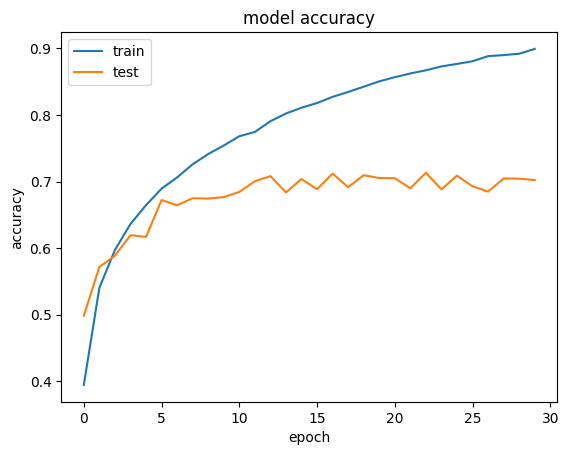

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()